In [14]:
# --- Cell 1: Setup & Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme()
plt.rcParams["figure.dpi"] = 120


In [2]:
# Cell 2: Load Data
# Adjust the filename if needed
CSV_PATH = "apartments_for_rent_classified_10K.csv"

# Robust loader: tries current folder, otherwise searches recursively
def load_csv(csv_guess=CSV_PATH):
    p = Path(csv_guess)
    if p.exists():
        return pd.read_csv(p, sep=None, engine="python", encoding="cp1252")
    hits = list(Path(".").rglob("apartments_for_rent_classified*.csv"))
    if not hits:
        raise FileNotFoundError(
            f"Could not find {csv_guess}. Put it next to the notebook or update CSV_PATH."
        )
    print(f"Found CSV at: {hits[0]}")
    return pd.read_csv(hits[0], sep=None, engine="python", encoding="cp1252")

df = load_csv()

# Clean column names
df.columns = (
    df.columns.astype(str)
      .str.strip()
      .str.lower()
      .str.replace(r"\s+", "_", regex=True)
)

# The assignment warns about 'price_display' leaking the target.
# Remove it if present.
if "price_display" in df.columns:
    df = df.drop(columns=["price_display"])

print(df.shape)
df.head()


(10000, 21)


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,...,790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,...,425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,...,1390,Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,...,925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,...,880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


In [3]:
# Cell 3: Quick EDA
print("Columns:", df.columns.tolist())
print("\nMissing values (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))

print("\nNumeric preview:")
display(df.select_dtypes(include=[np.number]).describe().T.head(10))


Columns: ['id', 'category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo', 'pets_allowed', 'price', 'price_type', 'square_feet', 'address', 'cityname', 'state', 'latitude', 'longitude', 'source', 'time']

Missing values (top 20):


pets_allowed    4163
amenities       3549
address         3327
state             77
cityname          77
bathrooms         34
latitude          10
longitude         10
bedrooms           7
body               0
title              0
category           0
id                 0
price_type         0
price              0
has_photo          0
fee                0
currency           0
square_feet        0
source             0
dtype: int64


Numeric preview:


,count,mean,std,min,25%,50%,75%,max
id,10000.0,5.623396e+09,7.021025e+07,5.508654e+09,5.509248e+09,5.668610e+09,5.668626e+09,5.668663e+09
bathrooms,9966.0,1.380544e+00,6.154099e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,8.500000e+00
bedrooms,9993.0,1.744021e+00,9.423539e-01,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,9.000000e+00
price,10000.0,1.486277e+03,1.076508e+03,2.000000e+02,9.490000e+02,1.270000e+03,1.695000e+03,5.250000e+04
square_feet,10000.0,9.458105e+02,6.557557e+02,1.010000e+02,6.490000e+02,8.020000e+02,1.100000e+03,4.000000e+04
latitude,9990.0,3.769516e+01,5.495851e+00,2.131550e+01,3.367985e+01,3.880980e+01,4.134980e+01,6.159400e+01
longitude,9990.0,-9.465225e+01,1.575980e+01,-1.580221e+02,-1.013017e+02,-9.365160e+01,-8.220998e+01,-7.019160e+01
time,10000.0,1.574891e+09,3.762395e+06,1.568744e+09,1.568781e+09,1.577358e+09,1.577359e+09,1.577362e+09


In [5]:
# Cell 4: Target & Custom Feature Transformer 

TARGET = "price"
assert TARGET in df.columns, f"'{TARGET}' not found in dataset!"

# Drop rows with missing target, ensure float
df = df.dropna(subset=[TARGET]).copy()
df[TARGET] = df[TARGET].astype(float)

# Simple user-defined transformer (required by the brief)
# Adds a 'bed_bath_ratio' and 'price_per_sqft' if columns exist
class AddCustomFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_features=True):
        self.add_features = add_features
        self._added_cols_ = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        self._added_cols_ = []
        if not self.add_features:
            return X

        # bed_bath_ratio
        if "bedrooms" in X.columns and "bathrooms" in X.columns:
            X["bed_bath_ratio"] = X["bedrooms"] / (X["bathrooms"].replace(0, np.nan))
            X["bed_bath_ratio"] = X["bed_bath_ratio"].fillna(0)
            self._added_cols_.append("bed_bath_ratio")

        # price_per_sqft (only for training preview; will be dropped before split if it leaks)
        # NOTE: We must NOT use target in transform. So this is commented out.
        # if "square_feet" in X.columns:
        #     X["price_per_sqft"] = y / (X["square_feet"].replace(0, np.nan))

        return X

# Split features/target
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Identify columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")


Numeric cols: 7 | Categorical cols: 13


In [ ]:
# Cell 5: Train/Test Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
len(X_train_raw), len(X_test_raw)


(8000, 2000)

In [7]:
# Cell 6: Preprocessing Pipelines

# Numeric pipeline: impute + scale (KNN/SVR benefit from scaling)
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

# Categorical pipeline: impute + one-hot
try:
    cat_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])
except TypeError:  # older sklearn
    cat_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse=True))
    ])

# Full feature preprocessor
feature_prep = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols)
])


In [9]:
# Cell 7: Helper to build a complete pipeline for a regressor
def make_regression_pipeline(model, add_features=True):
    return Pipeline([
        ("feats", AddCustomFeatures(add_features=add_features)),
        ("prep",  feature_prep),
        ("model", model),
    ])


In [10]:
# --- Cell 8: Train & Evaluate Models (no tuning) ---

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree":     DecisionTreeRegressor(random_state=42),
    "Random Forest":     RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "KNN Regressor":     KNeighborsRegressor(n_neighbors=5, weights="distance"),
}

results = {}
fitted  = {}

for name, est in models.items():
    pipe = make_regression_pipeline(est, add_features=True)
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    fitted[name]  = pipe

    print(f"{name:17s} | MAE: {mae:8.2f} | RMSE: {rmse:8.2f} | R²: {r2:6.3f}")

results_df = pd.DataFrame(results).T.sort_values("RMSE")
display(results_df)


Linear Regression | MAE:   321.61 | RMSE:   938.04 | R²:  0.011
Decision Tree     | MAE:   305.20 | RMSE:   600.19 | R²:  0.595
Random Forest     | MAE:   242.38 | RMSE:   478.48 | R²:  0.743
KNN Regressor     | MAE:   291.56 | RMSE:   557.81 | R²:  0.650


,MAE,RMSE,R2
Random Forest,242.384790,478.481754,0.742644
KNN Regressor,291.555411,557.806405,0.650240
Decision Tree,305.198500,600.185733,0.595075
Linear Regression,321.609220,938.038403,0.010891


In [18]:
# --- Naive Bayes (binned or plain classification) with DENSE features ---

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

# If you already have X_train, X_test, y_train, y_test, you can skip this split.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1) Identify column types from the TRAIN set
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# 2) Dense categorical encoder (version-compatible)
try:  # scikit-learn >= 1.2
    cat_enc_dense = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  # older versions
    cat_enc_dense = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  cat_enc_dense)   # <-- DENSE one-hot
])

# 3) ColumnTransformer that prefers dense output
#    - sparse_threshold=0 ensures it won’t return a scipy sparse matrix
preprocess_nb = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ],
    sparse_threshold=0.0
)

# 4) Final NB pipeline. The FunctionTransformer is a safety-net: if anything
#    still comes out sparse, it will be converted to a dense array.
to_dense = FunctionTransformer(
    lambda X: X.toarray() if hasattr(X, "toarray") else X,
    accept_sparse=True
)

nb_pipe = Pipeline(steps=[
    ("preprocessor", preprocess_nb),
    ("to_dense",     to_dense),       # <-- make absolutely sure it’s dense
    ("classifier",   GaussianNB())
])

# 5) Train
nb_pipe.fit(X_train, y_train)

# 6) Predict & evaluate
nb_pred = nb_pipe.predict(X_test)
print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))


Naive Bayes
Accuracy: 0.018
              precision    recall  f1-score   support

       325.0       0.00      0.00      0.00         1
       350.0       0.00      0.00      0.00         0
       386.0       0.00      0.00      0.00         1
       400.0       0.00      0.00      0.00         1
       415.0       0.00      0.00      0.00         1
       425.0       0.00      0.00      0.00         3
       450.0       0.00      0.00      0.00         3
       475.0       0.00      0.00      0.00         2
       480.0       0.00      0.00      0.00         0
       485.0       0.00      0.00      0.00         0
       490.0       0.00      0.00      0.00         0
       495.0       0.00      0.00      0.00         1
       499.0       0.00      0.00      0.00         0
       500.0       0.00      0.00      0.00         2
       510.0       0.00      0.00      0.00         0
       515.0       0.00      0.00      0.00         0
       525.0       0.00      0.00      0.00         0

c:\Users\noora\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\noora\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\noora\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

,Average Mistake Size,Typical Big Mistake,How Much it Explains (%)
Random Forest,242.384790,478.481754,74.264438
KNN Regressor,291.555411,557.806405,65.024021
Decision Tree,305.198500,600.185733,59.507534
Linear Regression,321.609220,938.038403,1.089106



 Compiled Results:
• Best by 'Typical Big Mistake' (lower is better): Random Forest
• Average Mistake Size: 242.38
• Typical Big Mistake: 478.48
• How Much it Explains: 74.3%


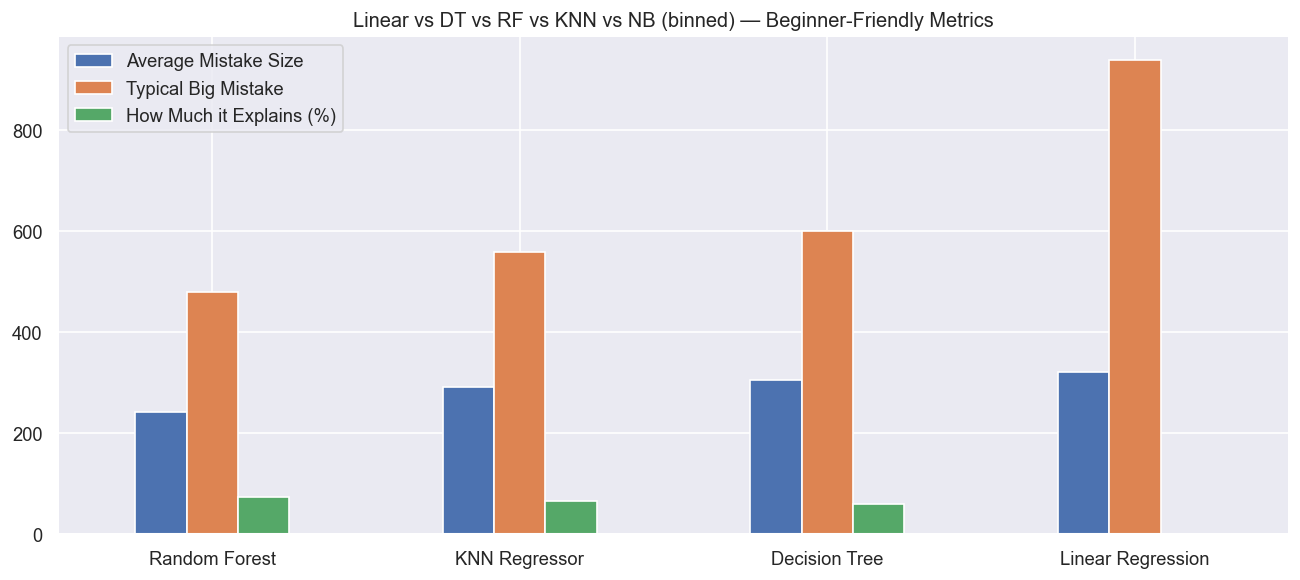

In [21]:
# --- Cell 10: Beginner-friendly summary + plot ---

friendly = results_df.copy()
friendly["Average Mistake Size"]      = friendly["MAE"]
friendly["Typical Big Mistake"]       = friendly["RMSE"]
friendly["How Much it Explains (%)"]  = friendly["R2"] * 100
friendly = friendly[["Average Mistake Size","Typical Big Mistake","How Much it Explains (%)"]]

display(friendly.sort_values("Typical Big Mistake"))

best_name = friendly["Typical Big Mistake"].idxmin()
print("\n Compiled Results:")
print(f"• Best by 'Typical Big Mistake' (lower is better): {best_name}")
print(f"• Average Mistake Size: {friendly.loc[best_name, 'Average Mistake Size']:.2f}")
print(f"• Typical Big Mistake: {friendly.loc[best_name, 'Typical Big Mistake']:.2f}")
print(f"• How Much it Explains: {friendly.loc[best_name, 'How Much it Explains (%)']:.1f}%")

ax = friendly.plot(kind="bar", figsize=(11,5))
plt.title("Linear vs DT vs RF vs KNN vs NB (binned) — Beginner-Friendly Metrics")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

if "Forest" in winner:
    print(f"Tuning {winner}…")
    base = make_regression_pipeline(RandomForestRegressor(random_state=42, n_jobs=-1))

    param_dist = {
        "model__n_estimators":      [150, 250, 350, 500],
        "model__max_depth":         [None, 10, 15, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf":  [1, 2, 4],
        "model__max_features":      ["sqrt", "log2", 0.5],
        "model__bootstrap":         [True, False],
    }

    search = RandomizedSearchCV(
        base,
        param_distributions=param_dist,
        n_iter=25, cv=3, n_jobs=-1, random_state=42,
        verbose=1, scoring="neg_root_mean_squared_error"
    )
    search.fit(X_train_raw, y_train)

    print("\nBest params:", search.best_params_)
    print("Best CV RMSE:", -search.best_score_)

    tuned = search.best_estimator_
    y_pred_tuned = tuned.predict(X_test_raw)

    mae_t  = mean_absolute_error(y_test, y_pred_tuned)
    rmse_t = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    r2_t   = r2_score(y_test, y_pred_tuned) * 100

    mae_b  = friendly.loc[winner, "Average Mistake Size"]
    rmse_b = friendly.loc[winner, "Typical Big Mistake"]
    r2_b   = friendly.loc[winner, "How Much it Explains (%)"]

    print("\n After Tuning (test set)")
    print(f"• Average Mistake Size: {mae_t:.2f}  (baseline {mae_b:.2f})")
    print(f"• Typical Big Mistake:  {rmse_t:.2f} (baseline {rmse_b:.2f})")
    print(f"• How Much it Explains: {r2_t:.1f}% (baseline {r2_b:.1f}%)")


Tuning Random Forest…
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best params: {'model__n_estimators': 150, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': None, 'model__bootstrap': False}
Best CV RMSE: 728.9817726225987

📈 After Tuning (test set)
• Average Mistake Size: 243.69  (baseline 242.38)
• Typical Big Mistake:  498.83 (baseline 478.48)
• How Much it Explains: 72.0% (baseline 74.3%)
